In [1]:
import matplotlib.pyplot as plt # for drawing graphs
import numpy as np
import imageio
import math
import cv2
from scipy import ndimage
import open3d as o3d
import time
from gradient import *
import warnings


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
path = "./data/" 

<bound method Figure.show of <Figure size 576x576 with 2 Axes>>

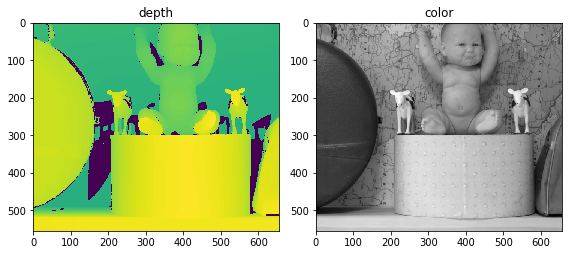

In [3]:
depth = imageio.imread(path+'disp1.png')
color = imageio.imread(path+'view1.png')
color = cv2.cvtColor(color, cv2.COLOR_RGB2GRAY).astype(np.float32)
fig,axes = plt.subplots(1,2,figsize = (8,8))
axes[0].imshow(depth)
axes[0].set_title("depth")
axes[1].imshow(color,cmap='gray')
axes[1].set_title("color")
fig.tight_layout()
fig.show

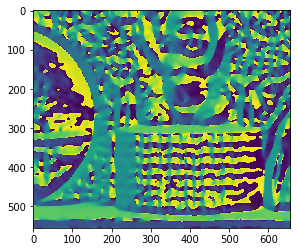

In [4]:
image_gx,image_gy = gauss_derivs(color, sigma=5)
direction = np.arctan2(image_gy , image_gx)
plt.imshow(direction)

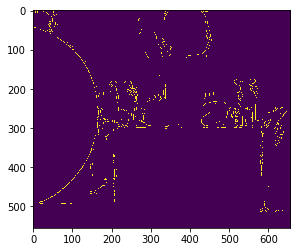

In [5]:
def getBordered(image,width):
    blank = np.ones((image.shape))
    ret, thresh = cv2.threshold(image,0, 8, 0)
    contours,hierarchy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.drawContours(blank, contours,-1, (0,255,0), width)
    img = (img==0)*1
    return img

def edge_get(image,th1,th2):
    if len(image.shape)==3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    img_blur = cv2.GaussianBlur(image,  (5,5), 3)
    edges = cv2.Canny(image=img_blur.astype(np.uint8), threshold1=th1, threshold2=th2, L2gradient=True) # Canny Edge Detection
    edges_c = edges.copy()
    edges_c[edges_c==0]=0
    edges_c[edges_c==255]=1
    return edges_c

h,w=color.shape[:2]
color_edge = edge_get(color,30,40)
depth_edge = edge_get(depth,30,60)

d = 3
color_edge_=cv2.copyMakeBorder(color_edge,d,d,d,d,cv2.BORDER_REFLECT)
depth_edge_=cv2.copyMakeBorder(depth_edge,d,d,d,d,cv2.BORDER_REFLECT)
for i in range(h):
    for j in range(w):
        if color_edge[i,j]==1:
            depth_w = depth_edge_[i:i+2*d+1,j:j+2*d+1]
            if not depth_w.any():
                color_edge[i,j] =0
plt.imshow(color_edge)


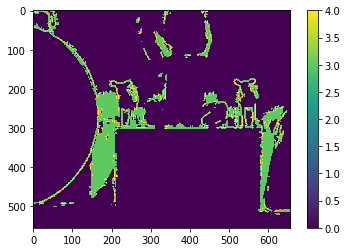

In [24]:
def mask_nonhole(depth,edge):
    """
    input edge:EI', depth map:D
    1 non-hole, non-edge JTF
    2 non-hole, edge DJBF 
    """
    mask = np.zeros(depth.shape)
    mask[(edge==0)&(depth!=0)]=1
    mask[(edge==1)&(depth!=0)]=2
    return mask

def mask_hole(depth,edge):
    mask = np.zeros(depth.shape)
    hole = getBordered(edge,3) 
    depth[hole==1]=0
    mask[(edge==0)&(depth==0)]=3
    mask[(edge==1)&(depth==0)]=4
    return mask
mask = mask_hole(depth,color_edge)

plt.imshow(mask)
plt.colorbar()
plt.show()

In [29]:
class Joint_bilateral_filter:
    def __init__(self,depth,color,mask,window_size,sigma_d,sigma_r):
        d = window_size//2
        gx,gy = gauss_derivs(color, sigma=5)
        self.direction = np.arctan2(gy , gx)
        self.d = d
        self.depth = depth.copy()
        self.color = color.copy()
        self.mask = mask.copy()
        self.depth_r = cv2.copyMakeBorder(depth,d,d,d,d,cv2.BORDER_REFLECT)
        self.color_r = cv2.copyMakeBorder(color,d,d,d,d,cv2.BORDER_REFLECT)
        self.mask_r = cv2.copyMakeBorder(mask,d,d,d,d,cv2.BORDER_REFLECT) 
        self.sigma_d = sigma_d
        self.sigma_r = sigma_r
        self.r,self.c=np.mgrid[-self.d:self.d+1:1,-self.d:self.d+1:1]   
        self.sum = 0
        
    def JBF(self,i,j,depth_w,color_w):

        remove_zero = (depth_w!=0)
        fg = np.exp(-(self.r**2+self.c**2)/(2*self.sigma_d**2))
        fr = np.exp(-(color_w-self.color[i,j])**2/(2*self.sigma_r**2))
        F = fg*fr
        F_ = np.sum(F*depth_w)/(np.sum(F*remove_zero)).astype(np.float32)
        return F_
    
    def JTF(self,i,j,depth_w,color_w):
        remove_zero = (depth_w!=0)
        fg = np.exp(-(self.r**2+self.c**2)/(2*self.sigma_d**2))
        fr = np.exp(-(color_w-self.color[i,j])**2/(2*self.sigma_r**2))
        fh = np.exp(-(depth_w-self.depth[i,j])**2/(2*self.sigma_r**2))
        T = fg*fr*fh
        T_ = np.sum(T*depth_w)/(np.sum(T*remove_zero)).astype(np.float32)
        return T_

        
    def DJBF(self,i,j,depth_w,color_w):
        remove_zero = (depth_w!=0)
        theta = self.direction[i,j]
        fr = np.exp(-(color_w-self.color[i,j])**2/(2*self.sigma_r**2))
        dx = self.r*np.cos(theta)-self.c*np.sin(theta) 
        dy = self.r*np.cos(theta)+self.c*np.sin(theta)
        sigma_dx = 3
        sigma_dy = 1
        fd = np.exp(-1/2*(dx/sigma_dx)**2+(dy/sigma_dy)**2)
        D = fd*fr
        D_ = np.sum(D*depth_w)/(np.sum(D*remove_zero))
        return D_

        
    def median_filter(self,i,j,depth_w,color_w):
        th_color=1
        g2 = np.exp(-(color_w-self.color[i,j])**2/(2*self.sigma_r**2)) 
        median_array = depth_w // g2 
        depth_w_list = depth_w.reshape(1,-1)[0].tolist()
        depth_w_list = [x for x in  depth_w_list if x>=th_color]
        median_list = median_array.reshape(1,-1)[0].tolist()
        median_list = [x for x in median_list if x>=th_color]
        if len(median_list)==0:
            M = 0
        else:    
            index = median_list.index(np.percentile(median_list,50,interpolation='nearest'))
            M = depth_w_list[index]     
        return M     
        
    def filter_mode(self,i,j):
        depth_w = self.depth_r[i:i+2*self.d+1,j:j+2*self.d+1]#*(mask_w==self.mask[i,j])
        color_w = self.color_r[i:i+2*self.d+1,j:j+2*self.d+1] 
        if depth_w.sum()==0:
            return
        if self.mask[i,j]==1:
            self.depth[i,j]=self.JTF(i,j,depth_w,color_w)
            self.sum+=1
        elif self.mask[i,j]==2:
            self.depth[i,j]=self.DJBF(i,j,depth_w,color_w)
            self.sum+=1
        elif self.mask[i,j]==3:
            self.depth[i,j]=self.JBF(i,j,depth_w,color_w)
            self.sum+=1
        elif self.mask[i,j]==4:
            self.depth[i,j]=self.DJBF(i,j,depth_w,color_w)
            self.sum+=1
        
 
    def run(self):
        h,w  = depth.shape
        for i in range(h):
            for j in range(w):
                self.filter_mode(i,j)
        print("total pixel filtered",self.sum)
        return self.depth



In [30]:
#non-hole area
time_start=time.time()    
warnings.filterwarnings('ignore')
mask1 = mask_nonhole(depth,color_edge)
non_hole = Joint_bilateral_filter(depth,color,mask1,8,10,5).run() 
time_end=time.time()
print('time cost',time_end-time_start)

total pixel filtered 321563
time cost 16.26217293739319


In [31]:
#hole area
time_start=time.time()    
warnings.filterwarnings('ignore')
mask2 = mask_hole(depth,color_edge)
hole = Joint_bilateral_filter(non_hole,color,mask2,30,10,5).run() 
hole = Joint_bilateral_filter(hole,color,mask2,10,10,5).run() 
time_end=time.time()
print('time cost',time_end-time_start)

total pixel filtered 40323
total pixel filtered 41780
time cost 9.897076845169067


<bound method Figure.show of <Figure size 720x1440 with 3 Axes>>

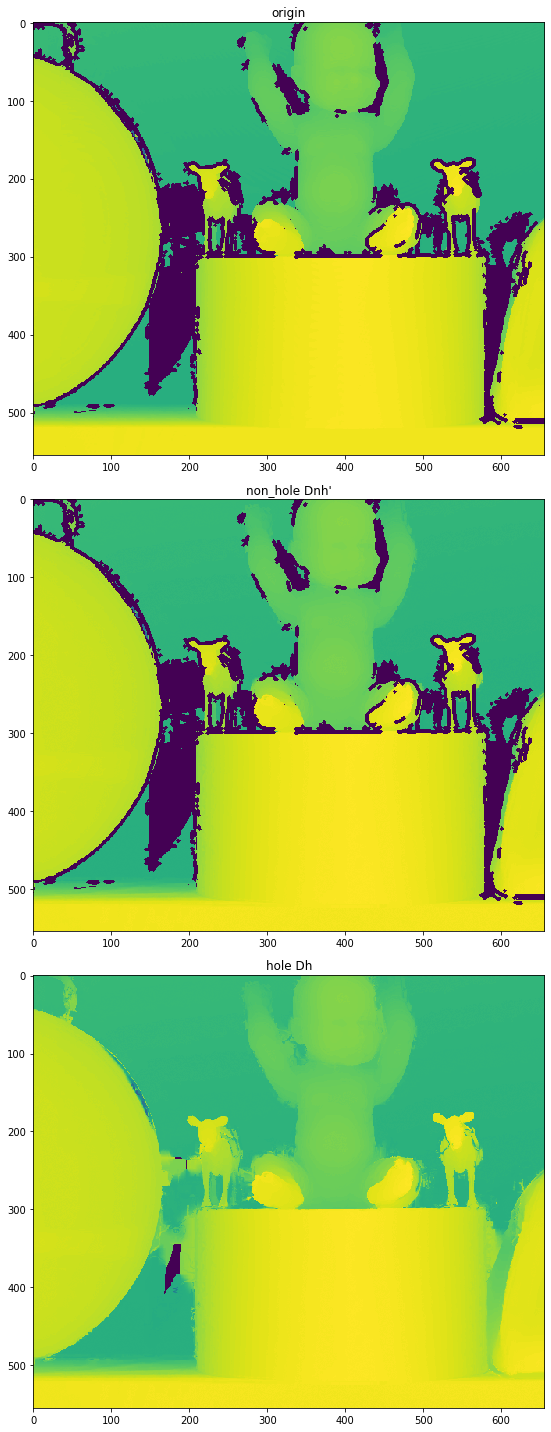

In [32]:
#visualization
fig,axes = plt.subplots(3,1,figsize = (10,20))
axes[0].imshow(depth)
axes[0].set_title("origin")
axes[1].imshow(non_hole)
axes[1].set_title("non_hole Dnh'")
axes[2].imshow(hole)
axes[2].set_title("hole Dh")
fig.tight_layout()
fig.show               